# Speech recognition

## Utils functions

In [1]:
from datasets import load_dataset, load_from_disk
import joblib
import os
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

d:\anaconda3\envs\cloudwalk\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_model(model, filename="random_forest_model.joblib"):
    """
    Saves the trained model to a file.

    Args:
        model: The trained scikit-learn model.
        filename (str): The name of the file to save the model to.
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename="random_forest_model.joblib"):
    """
    Loads a trained model from a file.

    Args:
        filename (str): The name of the file to load the model from.

    Returns:
        The loaded scikit-learn model.
    """
    if os.path.exists(filename):
        model = joblib.load(filename)
        print(f"Model loaded from {filename}")
        return model
    else:
        print(f"Model file not found at {filename}")
        return None

In [3]:
def load_dataset_from_hf_and_save_local(save_path="./dataset"):
    if os.path.exists(save_path):
        print(f"Loading dataset from local path: {save_path}")
        dataset = load_from_disk(save_path)
    else:
        print(f"Dataset not found locally. Downloading and saving to {save_path}...")
        dataset = load_dataset("mteb/free-spoken-digit-dataset")
        dataset.save_to_disk(save_path)
        print(f"Dataset downloaded and saved to {save_path}.")
    return dataset

In [4]:
def add_noise(track, noise_factor=0.01):
    noise = np.random.randn(len(track)) * noise_factor
    return track + noise

# For simpler model, we can easily just compute the mean, but
# we are losing the temporal information
def apply_mfcc_to_dataset(dataset_split, sr, noise_factor, n_mfcc=13):
    """
    Applies MFCC (Mel-frequency cepstral coefficients) extraction to a dataset split.

    Args:
        dataset_split (Dataset): A split of the Hugging Face dataset (e.g., dataset["train"]).
        n_mfcc (int): The number of MFCCs to return.

    Returns:
        list: A list of MFCC features for each audio sample in the dataset split.
    """

    X = []
    y = []

    for track in dataset_split:
        audio_array = track["audio"]["array"]
        audio_array = add_noise(audio_array, noise_factor)
        label = track["label"]
        mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_mfcc, n_fft = 512, hop_length=128)
        mfccs_mean = np.mean(mfccs, axis=1)
        X.append(mfccs_mean)
        y.append(label)
    return np.array(X), np.array(y)

In [5]:
def record_audio(duration, fs, channels=1):
    """
    Records audio from the microphone and saves it to a WAV file.

    Args:
        filename (str): The name of the file to save the audio to.
        duration (int): The duration of the recording in seconds.
        fs (int): The sampling rate (e.g., 44100 for CD quality).
        channels (int): The number of audio channels (1 for mono, 2 for stereo).
    """
    print(f"Recording for {duration} seconds with sampling rate {fs} Hz...")
    audio_data = sd.rec(int(duration * fs), samplerate=fs, channels=channels, dtype='int16')
    sd.wait()  # Wait until recording is finished
    print("Recording finished.")
    audio_data = audio_data.flatten()
    return audio_data

In [6]:
def inference(audio_data, model):
    audio_data_float = audio_data.astype(float)
    recorded_mfccs = librosa.feature.mfcc(y=audio_data_float, sr=sampling_rate, n_mfcc=13, n_fft=512, hop_length=128)
    recorded_mfccs_flat = np.mean(recorded_mfccs, axis=1).reshape(1, -1)
    predicted_label = model.predict(recorded_mfccs_flat)
    print(f"\nPredicted digit for the recorded audio: {predicted_label[0]}")

## Dataset loading and data analysis

In [7]:
dataset = load_dataset_from_hf_and_save_local()
print(f"Dataset structure: {dataset}")
print(f"Dataset sample: {dataset['train'][0]}")

Loading dataset from local path: ./dataset
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 2700
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 300
    })
})
Dataset sample: {'audio': {'path': '0_george_10.wav', 'array': array([-0.00534058, -0.01553345,  0.00894165, ..., -0.00283813,
       -0.00418091, -0.00271606], shape=(5958,)), 'sampling_rate': 8000}, 'label': 0}


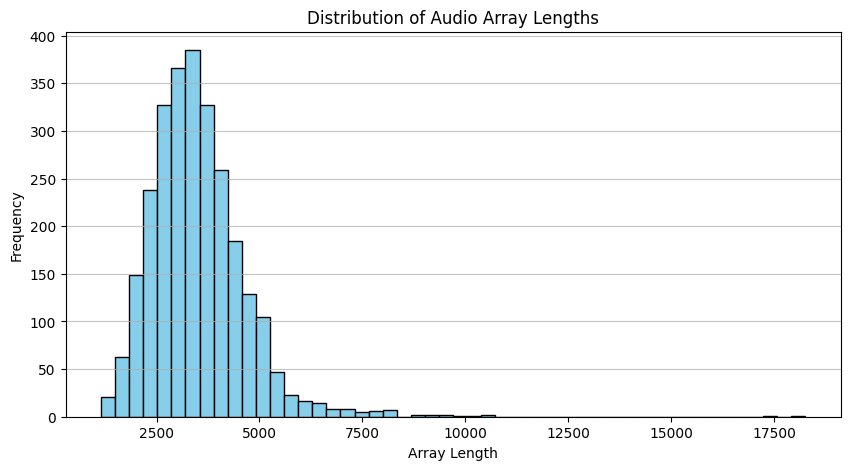

Sampling rates: [8000]


In [8]:
# Some dataset features
lengths = []
sampling_rates = []
for track in dataset["train"]:
    length = len(track["audio"]["array"])
    sampling_rate = track["audio"]["sampling_rate"]
    lengths.append(length)
    sampling_rates.append(sampling_rate)

# Plotting lengths histogram
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Array Lengths')
plt.xlabel('Array Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"Sampling rates: {np.unique(sampling_rates)}")


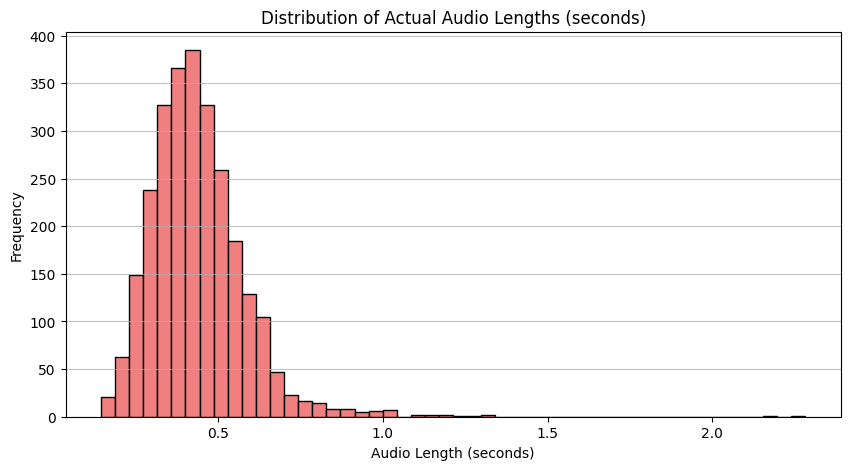

In [9]:
# Same sampling rate for every track. Different lengths.
# Let's see the lengths in seconds

# Convert array lengths to actual audio lengths
audio_lengths = [length / sampling_rate for length, sampling_rate in zip(lengths, sampling_rates)]

# Plotting audio_lengths histogram
plt.figure(figsize=(10, 5))
plt.hist(audio_lengths, bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Actual Audio Lengths (seconds)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [10]:
# Let's listen to some audio tracks
sampling_rate = sampling_rates[0]
audio_array = dataset["test"][150]["audio"]["array"]
ipd.display(ipd.Audio(audio_array, rate=sampling_rate))

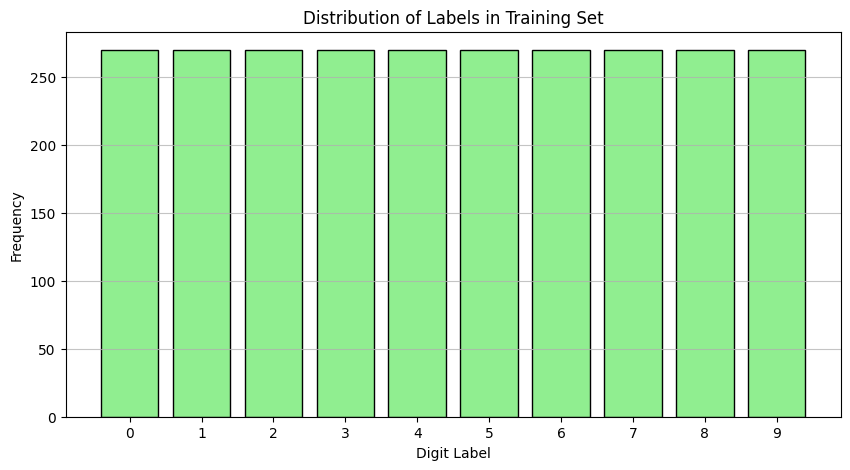

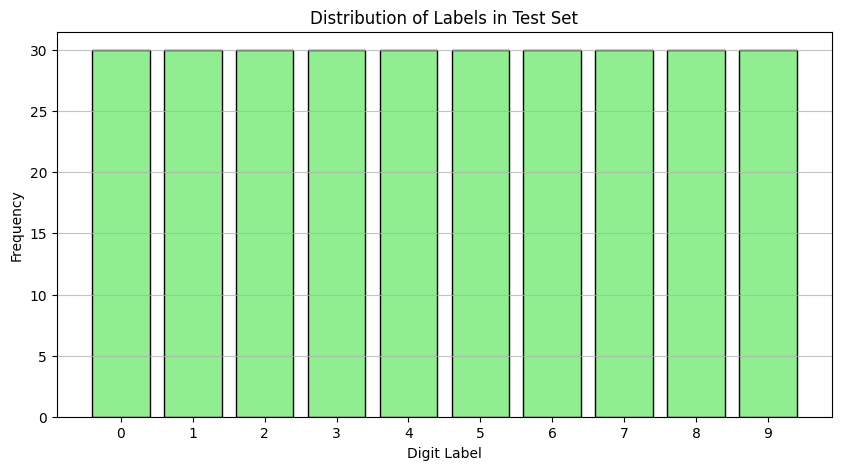

In [11]:
# Plotting label distribution
labels = [sample["label"] for sample in dataset["train"]]
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts, color='lightgreen', edgecolor='black')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plotting label distribution for the test set
labels_test = [sample["label"] for sample in dataset["test"]]
unique_labels_test, counts_test = np.unique(labels_test, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_labels_test, counts_test, color='lightgreen', edgecolor='black')
plt.title('Distribution of Labels in Test Set')
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels_test)
plt.grid(axis='y', alpha=0.75)
plt.show()


## Data processing



We want to apply MFCC to these tracks since they have all different lengths.

In [12]:
# We add noise factor, even if it makes the accuracy worse, because it helps recognize input from microphone better
noise_factor = 0

dataset_train = dataset["train"].shuffle(seed=42)
dataset_test = dataset["test"].shuffle(seed=42)
X_train, y_train = apply_mfcc_to_dataset(dataset_train, sampling_rate, noise_factor)
X_test, y_test = apply_mfcc_to_dataset(dataset_test, sampling_rate, noise_factor)

In [13]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2700, 13)
y_train shape: (2700,)
X_test shape: (300, 13)
y_test shape: (300,)


## Model training and model evaluation
In this task, we can evaluate the accuracy since it's a simple multiclass classification task with class balance. We could also evaluate the top-k to see if the model even when not making correct prediction.

Training RandomForestClassifier with n_estimators=100...
Model saved to random_forest_model.joblib
Evaluating model performance...

Accuracy: 0.9533

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.90      0.93      0.92        30
           2       0.97      0.97      0.97        30
           3       0.90      0.93      0.92        30
           4       1.00      1.00      1.00        30
           5       0.97      1.00      0.98        30
           6       0.97      0.93      0.95        30
           7       0.97      1.00      0.98        30
           8       0.94      0.97      0.95        30
           9       0.93      0.83      0.88        30

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



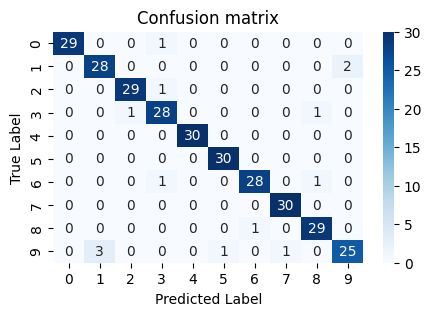

In [18]:
print(f"Training RandomForestClassifier with n_estimators={100}...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
save_model(model)
print("Evaluating model performance...")
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model works well. Let's try with sounds from microphone.

In [19]:
# Listen to the audio recorded
audio_data = record_audio(0.8, sampling_rate)
ipd.display(ipd.Audio(audio_data, rate=sampling_rate))

Recording for 0.8 seconds with sampling rate 8000 Hz...
Recording finished.


Load saved model and perform inference.

In [20]:
model = load_model()
inference(audio_data, model)

Model loaded from random_forest_model.joblib

Predicted digit for the recorded audio: 5


In [21]:
# Let's check if the code works for the test set
example = dataset["test"][150]
inference(example['audio']['array'], model)
print(f"\nActual digit for the recorded audio: {example['label']}")


Predicted digit for the recorded audio: 5

Actual digit for the recorded audio: 5


Model is not really good at predicting microphone inputs numbers. It is probably due to my microphone noise or difference in voice / environmental noise. We could try train the model again adding some noise to the train dataset.

Remember we have lost the temporal information when we did the mfcc. We could truncatin / padding, instead of evaluating the mean, and then use a small CNN or RNN to get better result. Anyway, the model perform well within the test dataset.

## Better model

This is a better model, with GRU and CNN, and it reaches better accuracy on the dataset, but still not good results on the voice recording. I did some data augmentation, but probably it is necessary to add some background noise, or to remove it from my recording to reach good results.

In [75]:
import numpy as np, random
import librosa, math
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

SR = 8000
N_MFCC = 13
USE_DELTAS = True
N_FFT = 512
HOP = 256                     # ≈ ~62 frames/sec at 8kHz
MAX_LEN = 64                  # pad/trunc to 64 frames (~1 sec)
N_CLASSES = 10
AUG_PROB = 0.6                # chance to apply augmentation to a training sample
EPOCHS = 50
BATCH = 64
SEED = 42

In [76]:
def augment_audio(y, sr=SR):
    if random.random() > AUG_PROB:
        return y
    choice = random.choice(["noise","gain","stretch","pitch","combo"])
    y_aug = y.copy()

    # small background Gaussian noise
    def add_noise(a, snr_db=25):
        # estimate power and add noise at desired SNR
        p_sig = np.mean(a**2) + 1e-9
        p_noise = p_sig / (10**(snr_db/10))
        noise = np.random.randn(len(a)) * math.sqrt(p_noise)
        out = a + noise
        return np.clip(out, -1, 1)

    # light time-stretch (keeps length diff; we'll pad/trunc later)
    def stretch(a, rate=None):
        rate = rate or random.uniform(0.9, 1.1)
        try:
            D = librosa.stft(a, n_fft=N_FFT)
            D_stretch = librosa.effects.time_stretch(D, rate=rate)
            return librosa.istft(D_stretch, length=int(len(a)/rate))
        except Exception:
            return a


    def pitch(a, steps=None):
        steps = steps or random.choice([-2,-1,1,2])
        try:
            return librosa.effects.pitch_shift(a, sr, n_steps=steps, n_fft=N_FFT)
        except Exception:
            return a

    # gain scale 0.7–1.3 then clip
    def gain(a, f=None):
        f = f or random.uniform(0.7, 1.3)
        return np.clip(a * f, -1, 1)

    if choice == "noise":
        y_aug = add_noise(y_aug, snr_db=random.choice([20,25,30]))
    elif choice == "gain":
        y_aug = gain(y_aug)
    elif choice == "stretch":
        y_aug = stretch(y_aug)
    elif choice == "pitch":
        y_aug = pitch(y_aug)
    elif choice == "combo":
        y_aug = add_noise(stretch(pitch(gain(y_aug))), snr_db=28)

    # ensure mono, normalized
    m = np.max(np.abs(y_aug)) + 1e-9
    y_aug = np.clip(y_aug / m, -1, 1)
    return y_aug

In [77]:
def mfcc_sequence(y, sr=SR, n_mfcc=N_MFCC, max_len=MAX_LEN):
    # resample if needed
    if sr != SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=SR)
        sr = SR
    # safe audio length (avoid very short signals exploding)
    if len(y) < N_FFT:
        y = np.pad(y, (0, N_FFT - len(y)))
    # MFCC (+ deltas)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=HOP)
    # ensure enough frames for delta computation
    if mfcc.shape[1] < 5:
        mfcc = np.pad(mfcc, ((0,0),(0, 5 - mfcc.shape[1])))

    if USE_DELTAS:
        delta = librosa.feature.delta(mfcc, width=3)
        delta2 = librosa.feature.delta(mfcc, order=2, width=3)
        feat = np.vstack([mfcc, delta, delta2])            # shape: (n_mfcc*3, T)
    else:
        feat = mfcc                                        # shape: (n_mfcc, T)

    feat = feat.T                                          # (T, F)

    # pad / truncate to fixed length
    T = feat.shape[0]
    if T < max_len:
        feat = np.pad(feat, ((0, max_len - T), (0,0)))
    else:
        feat = feat[:max_len, :]

    return feat.astype(np.float32)                          # (max_len, F)


In [113]:
def build_split(split, augment=False, n_augments=2):
    X, y = [], []
    for ex in tqdm(split):
        a = ex["audio"]["array"]
        sr = ex["audio"]["sampling_rate"]

        # always add original
        feat = mfcc_sequence(a, sr=sr)
        X.append(feat)
        y.append(ex["label"])

        if augment:
            for _ in range(n_augments):
                a_aug = augment_audio(a, sr)
                feat_aug = mfcc_sequence(a_aug, sr=sr)
                X.append(feat_aug)
                y.append(ex["label"])

    X = np.stack(X, axis=0)   # (N_aug, max_len, F)
    y = np.array(y, dtype=np.int64)
    return X, y


In [92]:
from tensorflow.keras import layers, models

def build_model(max_len=MAX_LEN, n_feats=N_MFCC*(3 if USE_DELTAS else 1), n_classes=N_CLASSES):
    inp = layers.Input(shape=(max_len, n_feats))
    x = layers.Masking(mask_value=0.0)(inp)

    # First Conv Block
    x = layers.Conv1D(32, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.15)(x)   # lighter dropout

    # Second Conv Block
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.15)(x)   # lighter dropout

    # GRU Layer
    x = layers.GRU(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)

    # Dense Block
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)   # moderate dropout

    # Output Layer
    out = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [114]:
print("Preparing data...")
X_train, y_train = build_split(dataset["train"], augment=True)
X_test,  y_test  = build_split(dataset["test"],  augment=False)

Preparing data...


100%|██████████| 300/300 [00:02<00:00, 126.76it/s]


In [115]:
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

Shape X_train: (8100, 64, 39)
Shape X_test: (300, 64, 39)


In [116]:
model = build_model(n_feats=X_train.shape[-1])
model.summary()

d:\anaconda3\envs\cloudwalk\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 39)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_4 (Masking)             │ (None, 64, 39)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 64, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 32, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,618 (393.04 KB)

 Trainable params: 100,298 (391.79 KB)

 Non-trainable params: 320 (1.25 KB)

In [117]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
]

In [118]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.1067 - loss: 2.4713 - val_accuracy: 0.1433 - val_loss: 2.2929 - learning_rate: 0.0010
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.2300 - loss: 2.0316 - val_accuracy: 0.4633 - val_loss: 1.5204 - learning_rate: 0.0010
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6020 - loss: 1.1009 - val_accuracy: 0.7167 - val_loss: 0.7364 - learning_rate: 0.0010
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8607 - loss: 0.4773 - val_accuracy: 0.9100 - val_loss: 0.2775 - learning_rate: 0.0010
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9433 - loss: 0.2194 - val_accuracy: 0.9833 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9638 - loss: 0.1366 - val_accuracy: 0.9833 - val_loss: 0.0568 - learning_rate: 0.0010
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9717 - loss: 0

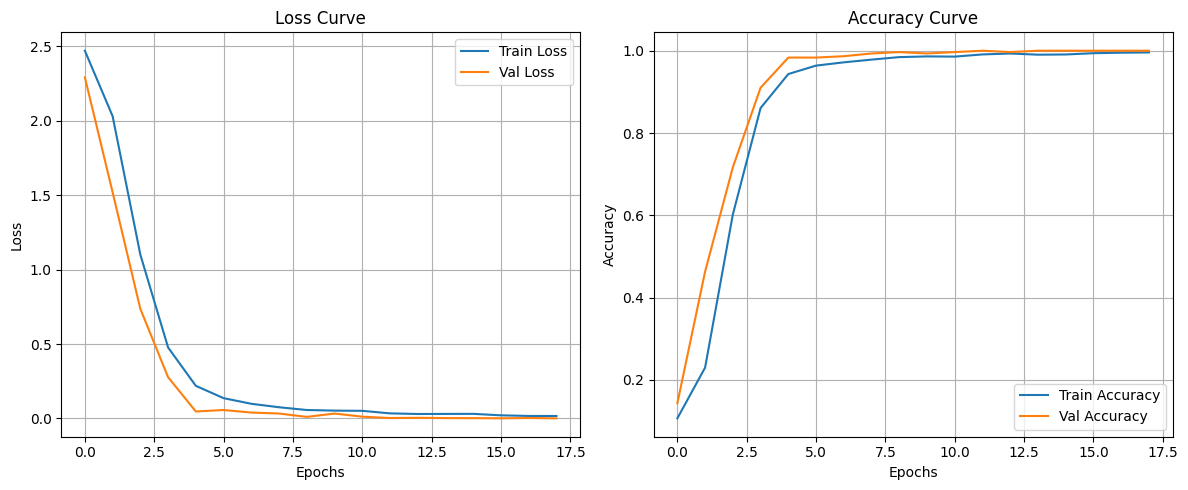

In [119]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot loss
    plt.figure(figsize=(12,5))

    # Loss curve
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1,2,2)
    if 'accuracy' in history.history:  
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'No accuracy data found in history',
                 ha='center', va='center')

    plt.tight_layout()
    plt.show()

plot_history(history)


In [147]:
# Evaluate
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test accuracy: {test_acc:.4f}")

# Save
model.save("cnn_model.h5")
print("Saved model to cnn_model.h5")

Test accuracy: 1.0000
Saved model to cnn_model.h5
